<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Startline" data-toc-modified-id="Startline-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Startline</a></span><ul class="toc-item"><li><span><a href="#start-time" data-toc-modified-id="start-time-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>start time</a></span></li><li><span><a href="#position-buoys" data-toc-modified-id="position-buoys-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>position buoys</a></span></li><li><span><a href="#wind-measurement-on-RC" data-toc-modified-id="wind-measurement-on-RC-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>wind measurement on RC</a></span></li><li><span><a href="#Determine-startline-stats" data-toc-modified-id="Determine-startline-stats-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Determine startline stats</a></span></li><li><span><a href="#position-competitors" data-toc-modified-id="position-competitors-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>position competitors</a></span></li><li><span><a href="#Determine-competitor-start-positions" data-toc-modified-id="Determine-competitor-start-positions-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Determine competitor start positions</a></span></li><li><span><a href="#All-together-for-every-race" data-toc-modified-id="All-together-for-every-race-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>All together for every race</a></span></li><li><span><a href="#draft" data-toc-modified-id="draft-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>draft</a></span><ul class="toc-item"><li><span><a href="#get-wind" data-toc-modified-id="get-wind-1.8.1"><span class="toc-item-num">1.8.1&nbsp;&nbsp;</span>get wind</a></span></li></ul></li></ul></li><li><span><a href="#Correlations-per-race-(first-leg)" data-toc-modified-id="Correlations-per-race-(first-leg)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Correlations per race (first leg)</a></span></li></ul></div>

In [1]:
### correlations per race
# welke factoren waren belangrijk in een race

from sqlalchemy import *
from sqlalchemy.exc import IntegrityError, InternalError
import numpy as np
import pandas as pd
import pyodbc
import matplotlib.pyplot as plt
import urllib, json, requests
from math import *


import os, sys, inspect, json
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)
from lib.Utilities.globalVar import *
import lib.TransformData.combineData as comd
import Download.download as download
from Utilities.converter import *

cd = comd.combineData()

In [2]:
## new server
server = 'sic-match-analysis.database.windows.net'
database = 'match-analysis'
username = 'sic-admin'
password = 'ZeilenIsLeuk!'
driver= '{ODBC Driver 17 for SQL Server}'
connection_str = 'DRIVER='+driver+';SERVER='+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+ password
quoted = urllib.parse.quote_plus(connection_str)
engine = create_engine('mssql+pyodbc:///?odbc_connect={}'.format(quoted), fast_executemany=True)

cnxn = pyodbc.connect(connection_str)
cursor = cnxn.cursor()

# Startline

In [82]:
regName = 'HWCS 2020 Round 1 - Laser'
raceName = 'R09 (Laser Standard)'

def idToText(id): #TODO move to utilities
    return "0x{}".format(id.hex().upper())

    
def toDeg(a):
    return a*360/(2*pi)

def toRad(a):
    return a*2*pi/360

## start time

In [83]:

sql = """SELECT  *
  FROM races
  WHERE regatta = '{}'
  and race = '{}'""".format(regName, raceName)
race = pd.read_sql_query(sql, con = engine, index_col=None, coerce_float=True, params=None, parse_dates=None, chunksize=None)

st = race['startOfRace-ms'].values[0] ## start time


## position buoys

In [84]:
sql = """SELECT  *
  FROM courses
  WHERE regatta = '{}'
  and race = '{}'
  and mark_nr = 0""".format(regName, raceName)
start = pd.read_sql_query(sql, con = engine, index_col=None, coerce_float=True, params=None, parse_dates=None, chunksize=None)

id_l = start['controlPoint.left.id'].values[0]  #RC
id_r = start['controlPoint.right.id'].values[0] #Pin

sql = """SELECT  *
  FROM marks_positions
  WHERE regatta = '{}'
  and race = '{}'
  and (id = {} or id = {})
  and [timepoint-ms] <= {}+1000
  and [timepoint-ms] >= {}-1000""".format(regName, raceName, idToText(id_l), idToText(id_r), st,st)
st_line = pd.read_sql_query(sql, con = engine, index_col=None, coerce_float=True,
                           params=None, parse_dates=None, chunksize=None).set_index('id')
st_line

,regatta,race,lat-deg,lng-deg,timepoint-ms
id,,,,,
b'#\xa3\xb7\x10\xa9\xf7\x017\xb7\x11\x06w?\x91rv',HWCS 2020 Round 1 - Laser,R09 (Laser Standard),35.271924,139.484165,1567229701000
b'(\x18%\x90\xa9\xf7\x017\xb7\xbc\x06w?\x91rv',HWCS 2020 Round 1 - Laser,R09 (Laser Standard),35.270982,139.486532,1567229699000


## wind measurement on RC

In [85]:
sql = """SELECT  *
  FROM wind
  WHERE regatta = '{}'
  and race = '{}'
  """.format(regName, raceName)
wind = pd.read_sql_query(sql, con = engine, index_col=None, coerce_float=True, params=None, parse_dates=None, chunksize=None)



In [86]:
rc = st_line.loc[id_l,:]
dist = wind[['lat-deg', 'lng-deg']].apply(lambda x: np.linalg.norm([x['lat-deg']- rc['lat-deg'],x['lng-deg']- rc['lng-deg']]),
                                   axis = 1)


In [87]:
source = wind.loc[dist.idxmin()]
wind_msr = wind.loc[(wind.windSource_id == source.windSource_id) & (wind['timepoint-ms'] == st)].reset_index()
wind_msr
# wind_msr.loc[wind_msr['timepoint-ms'] == st] 

,index,regatta,race,windSource,windSource_id,trueBearing-deg,speed-kts,speed-m/s,timepoint-ms,dampenedTrueBearing-deg,dampenedSpeed-kts,dampenedSpeed-m/s,lat-deg,lng-deg
0,34387,HWCS 2020 Round 1 - Laser,R09 (Laser Standard),EXPEDITION,DC-GD-AAEF,10.1,17.7,9.1,1567229700000,11.9,16.3,8.4,35.271828,139.484159


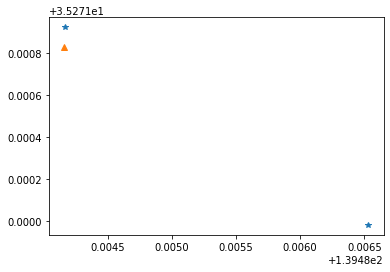

In [88]:
plt.plot(st_line['lng-deg'], st_line['lat-deg'], '*')
plt.plot(wind_msr['lng-deg'], wind_msr['lat-deg'], '^')
plt.show()

## Determine startline stats
favourable side (PIN, RC)
difference angle wind and line


In [89]:

def bearing(a,b): ## a and b in lat and longitude
    lat1 = toRad(a['lat-deg'])
    lat2 = toRad(b['lat-deg'])
    lon1 = toRad(a['lng-deg'])
    lon2 = toRad(b['lng-deg'])
    
    y = sin(lon2-lon1)*cos(lat2)
    x = cos(lat1)*sin(lat2)-sin(lat1)*cos(lat2)*cos(lon2-lon1)
    theta = atan2(y,x)
    return toDeg(theta)

In [90]:
pin = st_line.loc[id_r,:]
bearing_st = bearing(rc,pin)
dir_diff = wind_msr.loc[0,'trueBearing-deg'] - (bearing_st - 90) ## denk na over modulo rekenen, zodat alles tussen -40 + 40 komt
dir_diff = ((dir_diff+ 180)%360) - 180

In [91]:
if dir_diff<0:
    side = 'Left'
else:
    side = 'Right'

In [92]:
## update races table

cursor.execute("""UPDATE races
                SET races.stl_bearing_diff_wind = {}
                , races.stl_fav_side = '{}'
                WHERE regatta = '{}'
                    AND race = '{}'
                """.format(dir_diff, side, regName, race['race']))
cursor.commit()


## position competitors

In [93]:

sql = """select p.*
        from positions p
        join (select regatta, race, comp_id, min(timepoint_ms) as t
              from positions
              group by regatta, race, comp_id) p2
            on p.regatta = p2.regatta and p.race = p2.race and p.comp_id = p2.comp_id and p.timepoint_ms = p2.t
        Inner join comp_leg as cl on 
                p.regatta = cl.regatta and p.race = cl.race and p.comp_id = cl.comp_id and p.leg_nr = cl.leg_nr
        where 
        p.regatta = '{}'
        and p.race = '{}'
        and cl.competitor_started = 1 and cl.leg_nr = 1
""".format(regName, raceName)
comp = pd.read_sql_query(sql, con = engine, index_col=None, coerce_float=True, params=None, parse_dates=None, chunksize=None)



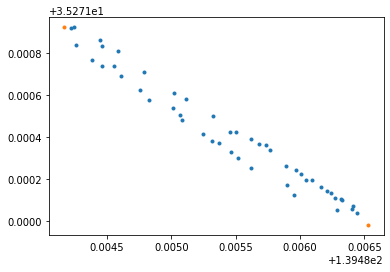

In [94]:
plt.plot(comp['lng-deg'], comp['lat-deg'], '.')
plt.plot(st_line['lng-deg'], st_line['lat-deg'], '.')
plt.show()

## Determine competitor start positions
absolute on line and relative

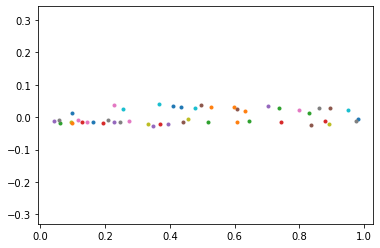

In [95]:
def startline(track_df, pin, rc):
    #transform to equidistant field
    phi_0 = pin['lat-deg'] ## latitude
    l_0 = pin['lng-deg'] ## longitude
    x = np.array(cos(phi_0 * 2 * pi/360) * (track_df['lng-deg']- l_0))
    y = np.array( track_df['lat-deg']- phi_0)
    
    rc_x = cos(phi_0 * 2 * pi/360) * (rc['lng-deg']- l_0)
    rc_y = rc['lat-deg'] - phi_0
    
    #rotate and scale competitors
    theta = -atan2(rc_y,rc_x)
    T = np.matrix([[cos(theta), -sin(theta)],[sin(theta), cos(theta)]])
    X = T*np.matrix([x,y])
    rc = T*np.matrix([[rc_x],[rc_y]])
    X = X/rc[0]
    plt.plot(X[0], X[1], '.')
    plt.axis('equal')
    plt.show()
    return np.asarray(X)[0]

x = startline(comp, pin, rc)
comp['pos_startline_abs'] = x
rel_order = x.argsort().argsort()
comp['pos_startline_rel'] = rel_order


In [96]:
## Update race_comp
for idx, competitor in comp.iterrows():
    sql = """UPDATE race_comp
                SET race_comp.pos_startline_abs = {}
                , race_comp.pos_startline_rel = {}
                WHERE regatta = '{}'
                    AND race = '{}'
                    AND comp_id = {}
                """.format(competitor.pos_startline_abs,
                           competitor.pos_startline_rel,
                           regName,
                           raceName,
                          idToText(competitor.comp_id))
    cursor.execute(sql)
    cursor.commit()
    


## All together for every race

In [3]:
###############################
## Tabellen vullen
###############################
import os, sys, inspect, json
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)
from lib.Utilities.globalVar import *
import lib.TransformData.combineData as combd
import Download.download as download
from Utilities.converter import *

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)
from sqlalchemy import *
from sqlalchemy.exc import IntegrityError, InternalError
from sqlalchemy.types import BINARY, VARCHAR
import pandas as pd
import numpy as np
from math import *
import urllib, json, requests


import pyodbc


from sqlalchemy.types import TypeDecorator, CHAR
from sqlalchemy.dialects.postgresql import UUID
import uuid

In [17]:

server = 'sic-match-analysis.database.windows.net'
database = 'match-analysis'
username = 'sic-admin'
password = 'ZeilenIsLeuk!'
driver= '{ODBC Driver 17 for SQL Server}'
connection_str = 'DRIVER='+driver+';SERVER='+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+ password


cnxn = pyodbc.connect(connection_str)
cursor = cnxn.cursor()

quoted = urllib.parse.quote_plus(connection_str)
engine = create_engine('mssql+pyodbc:///?odbc_connect={}'.format(quoted))

from sqlalchemy import event

@event.listens_for(engine, 'before_cursor_execute')
def receive_before_cursor_execute(conn, cursor, statement, params, context, executemany):
    if executemany:
        cursor.fast_executemany = True
        cursor.commit()

In [5]:
## Lukt niet om met bulk insert vanaf locale dir bestanden up te loaden :( dus moet via pandas to_sql
# cursor.execute("""
# BULK INSERT regattas
# FROM '\\usman-ess/Folder Redirection/Nerine/Documents/TU_Delft/2_Master/3_Stage/2_Code/SAPDataAnalysis/data/raw/tokyo2019'
# """)
event  = [{'name' :  'hwcs2020-round1', 'AllRegattas': True, 'regattaNameContaining': '', 'raceNameContaining': ''}
         ,{'name' : 'www', 'AllRegattas' : False, 'regattaNameContaining': 'Enoshima', 'raceNameContaining': ''}
         ,{'name' :  'tokyo2019', 'AllRegattas': True, 'regattaNameContaining': '', 'raceNameContaining': ''}]
events = [{'name' :  'tokyo2019', 'AllRegattas': True, 'regattaNameContaining': '', 'raceNameContaining': ''}]
eventSelection = event
parentdir

'X:\\TU_Delft\\2_Master\\3_Stage\\2_Code\\SAPDataAnalysis'

In [6]:
## TABLE 1 regattas
for serv in eventSelection:
    filepath = parentdir + '/' +  outdirbase + serv['name'] + '/regattas'
    with open(filepath + '.json') as json_file:
#         print('file extracted: ', filepath)
        data = json.load(json_file)
    cd = combd.combineData(serv)
    df = cd.transformJsonToPD(data, 'regattas')
    serv['regattas'] = df
#     try:
#         df.to_sql('regattas', con = engine, index = False, if_exists = 'append')
#         print('Succesfully added regattas of {} to the database'.format(serv['name']))
#     except IntegrityError as e:
#         print('Could not add regattas of {} to the database because of IntegrityError: {}'.format(serv['name'], e))
    


In [7]:
# https://www.movable-type.co.uk/scripts/latlong.html



def idToText(id): #TODO move to utilities
    return "0x{}".format(id.hex().upper())

    
def toDeg(a):
    return a*360/(2*pi)

def toRad(a):
    return a*2*pi/360



def bearing(a,b): ## a and b in lat and longitude
    lat1 = toRad(a['lat-deg'])
    lat2 = toRad(b['lat-deg'])
    lon1 = toRad(a['lng-deg'])
    lon2 = toRad(b['lng-deg'])
    
    y = sin(lon2-lon1)*cos(lat2)
    x = cos(lat1)*sin(lat2)-sin(lat1)*cos(lat2)*cos(lon2-lon1)
    theta = atan2(y,x)
    return toDeg(theta)

def startline(track_df, pin, rc):
    #transform to equidistant field
    phi_0 = pin['lat-deg'] ## latitude
    l_0 = pin['lng-deg'] ## longitude
    x = np.array(cos(phi_0 * 2 * pi/360) * (track_df['lng-deg']- l_0))
    y = np.array( track_df['lat-deg']- phi_0)
    
    rc_x = cos(phi_0 * 2 * pi/360) * (rc['lng-deg']- l_0)
    rc_y = rc['lat-deg'] - phi_0
    
    #rotate and scale competitors
    theta = -atan2(rc_y,rc_x)
    T = np.matrix([[cos(theta), -sin(theta)],[sin(theta), cos(theta)]])
    X = T*np.matrix([x,y])
    rc = T*np.matrix([[rc_x],[rc_y]])
    X = X/rc[0]
#     plt.plot(X[0], X[1], '.')
#     plt.axis('equal')
#     plt.show()
    return X

In [8]:
sql = """
SELECT * from legs 
where pos_startline_abs_x IS NULL and
correlation_side is not null
and leg_nr = 1

"""


eventSelection = pd.read_sql(sql, con= engine)
eventSelection

,regatta,race,leg_nr,fromWaypointId,toWaypointId,to,from,upOrDownwindLeg,leg_nr_from_finish,distance,correlation_tacks,correlation_side,correlation_avgSOG,correlation_traveledDistance,correlation_jibes,pos_startline_abs_x,pos_startline_abs_y,pos_startline_rel,cor_side_pos_startline_abs,cor_side_pos_startline_rel
0,Tokyo 2019 - RS:X Women,R1 (RS:X Women),1,"b'\xe4$\x14r\xf2\xbcI\xed\x8a,\xaa\xa6+\x89\xfdD'",b'\xc4\xc2\xd23|hO\xa6\xb5\xb8o&\xa3v\xd2\xdd',W-1,W - Start,True,5,None,-0.2586,0.3705,-0.2870,0.7203,NaN,None,None,None,None,None
1,Tokyo 2019 - RS:X Women,R10 (RS:X Women),1,b'\xe1\x8a\xde\x81\x06<O\xfe\x84\xae\x1e\x0e_5...,b'X~\xfa\xca3\xa6L\xf9\xa9(\xd8\xdf5Y\xc4B',W-1,W - Start,True,6,None,0.2426,-0.1444,-0.0804,0.6309,0.1636,None,None,None,None,None
2,Tokyo 2019 - RS:X Women,R11 (RS:X Women),1,b'i\xde\x9c\x00n\x80K9\x92\xb1\x91\x1c\x1ad\xb...,b'\x85\x14\x9d\x9a\xf4\n@q\x8bDZrxo\x07\xa6',W-1,W - Start,True,6,None,0.1065,0.7157,-0.2676,0.5755,NaN,None,None,None,None,None
3,Tokyo 2019 - RS:X Women,R12 Medal (RS:X Women),1,b'\xa9\x8c}b\xa3\x04N<\x99F\x85]l\xa9#\xcd',b'\x17\x16\x14\xc1t\xbeJ\xe8\x94\xdf\x1d\x94b\...,W-1,W - Start,True,5,None,0.7977,-0.6687,-0.8099,-0.3754,NaN,None,None,None,None,None
4,Tokyo 2019 - RS:X Women,R2 (RS:X Women),1,b'\x87\x0bIr\xea\nB\xff\x85{&Be\x9b\xeb\xf6',b'\x07:?6%\x81J\x8a\xb3\xe4U\\S\xdc\x06\x13',W-1,W - Start,True,5,None,0.5290,0.2411,-0.3134,0.6899,NaN,None,None,None,None,None
5,Tokyo 2019 - RS:X Women,R3 (RS:X Women),1,b'\x87W\n\xd4\xc9\xc3NW\x8d\xc0Z\x8ct\x08\xb8/',b'\xf1\xf6v\x94\x06gF\xcb\xa4v\x14\xf4Z8\x11\xb8',W-1,W - Start,True,5,None,0.1621,0.0339,-0.3196,0.8389,NaN,None,None,None,None,None
6,Tokyo 2019 - RS:X Women,R4 (RS:X Women),1,b'\x99\xdc\xa6D1\xdaN\xb6\x9b\xaa\xdd\x95>\xe9...,b'\x897\xdf\xb7\xca\xb9F\x8b\x94\x9e\xe2\xde\x...,W-1,W - Start,False,5,None,0.0264,-0.4246,-0.8082,0.5028,-0.0871,None,None,None,None,None
7,Tokyo 2019 - RS:X Women,R5 (RS:X Women),1,b'\r\xab\xaa\x80\xb2\xbfEU\x9e!\xb5[\xf2\xa3o\...,b'Ts\xdc\xf6\xd9\xd6B\x02\x9d\xdaC\xbal\xe8{\x18',W-1,W - Start,True,5,None,0.1503,-0.7553,-0.2778,0.4595,NaN,None,None,None,None,None
8,Tokyo 2019 - RS:X Women,R6 (RS:X Women),1,b'!y}\xce\x05iB\x85\x8bP\xe3Fs\xb2\xb6\x04',"b'\x19wK\xb4H\xf4L\xce\x90\x9c\xea#\xfb\x9aV,'",W-1,W - Start,True,6,None,0.1253,0.0114,-0.4016,0.0433,NaN,None,None,None,None,None
9,Tokyo 2019 - RS:X Women,R7 (RS:X Women),1,"b""\x9fw\xcf\xf4\xcapK'\xa2\xbaXH\xc3\x1fV\x10""",b'\x01\x82Y\xaa\xc5\xfcD\x9e\xb6cd\xdc\x9d\xa6...,W-1,W - Start,True,6,None,0.4822,-0.4148,-0.6537,0.1701,NaN,None,None,None,None,None


competitor start locations already known for Tokyo 2019 - RS:X Women R1 (RS:X Women)
competitor start locations already known for Tokyo 2019 - RS:X Women R10 (RS:X Women)
competitor start locations already known for Tokyo 2019 - RS:X Women R11 (RS:X Women)
competitor start locations already known for Tokyo 2019 - RS:X Women R12 Medal (RS:X Women)
competitor start locations already known for Tokyo 2019 - RS:X Women R2 (RS:X Women)
competitor start locations already known for Tokyo 2019 - RS:X Women R3 (RS:X Women)
competitor start locations already known for Tokyo 2019 - RS:X Women R4 (RS:X Women)
competitor start locations already known for Tokyo 2019 - RS:X Women R5 (RS:X Women)
competitor start locations already known for Tokyo 2019 - RS:X Women R6 (RS:X Women)
competitor start locations already known for Tokyo 2019 - RS:X Women R7 (RS:X Women)
competitor start locations already known for Tokyo 2019 - RS:X Women R8 (RS:X Women)
competitor start locations already known for Tokyo 2019 

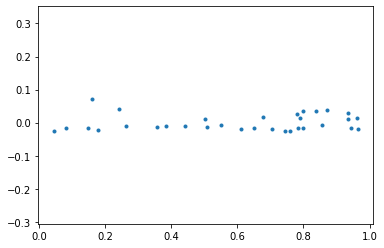

Succesfully updated startline for HWCS 2020 Round 1 - 470 Men R1 (470 Men)
Startline not complete for WCS 2019 Enoshima - Laser Radial R6
Startline not complete for WCS 2019 Enoshima - Laser Radial R7


In [23]:
for indx, row in eventSelection.iterrows():    
    regName = row.regatta
    raceName = row.race
    ## Start time
    sql = """SELECT  *
      FROM races
      WHERE regatta = '{}'
      and race = '{}'""".format(regName, raceName)
    race = pd.read_sql_query(sql, con = engine, index_col=None, coerce_float=True,
                             params=None, parse_dates=None, chunksize=None)

    st = race['startOfRace-ms'].values[0] ## start time
    if st is None:
        print('\t No start time found for {} {}'.format(regName, raceName))
        continue


    print('Updating Startline', end = '\r')


    ## position buoys
    sql = """SELECT  *
      FROM courses
      WHERE regatta = '{}'
      and race = '{}'
      and mark_nr = 0""".format(regName, raceName)
    start = pd.read_sql_query(sql, con = engine, index_col=None, coerce_float=True,
                              params=None, parse_dates=None, chunksize=None)

    id_l = start['controlPoint.left.id'].values[0]  #RC
    id_r = start['controlPoint.right.id'].values[0] #Pin

    sql = """SELECT  *
      FROM marks_positions
      WHERE regatta = '{}'
      and race = '{}'
      and (id = {} or id = {})
      and [timepoint-ms] <= {}+3000
      and [timepoint-ms] >= {}-3000""".format(regName, raceName, idToText(id_l), idToText(id_r), st,st)
    st_line = pd.read_sql_query(sql, con = engine)
    #select one timepoint
    if st_line.empty:
        print("\tNo startline available for {} {}".format(regName, raceName))
        continue
    mask = st_line[['id', 'timepoint-ms']].groupby('id').idxmin()['timepoint-ms']
    st_line = st_line.loc[mask].set_index('id')            
    
    if len(st_line)<2:
        print('Startline not complete for {} {}'.format(regName, raceName))
        continue
    rc = st_line.loc[id_l,:]
    pin = st_line.loc[id_r,:]
    st_bearing = bearing(rc,pin)        
        
    ## windmeasurements at start
    skip_wind = 0
    sql = """SELECT * FROM windsources
                    WHERE regatta = '{}'
                        AND race = '{}'
                        AND typeName = 'EXPEDITION'""".format(regName, raceName)
    windsources = pd.read_sql_query(sql, con = engine)
    rc_windsource = windsources.loc[windsources.rc == 1]
    
    if rc_windsource.empty:
         ## wind measurement at RC
        print('Get windsources', end = '\r')
        sql = """SELECT  *
            FROM wind
            WHERE regatta = '{}'
            and race = '{}'
            and [timepoint-ms] <= {}+3000
            and [timepoint-ms] >= {}-3000
            """.format(regName, raceName, st, st)
        wind = pd.read_sql_query(sql, con = engine)
        wind = wind.loc[wind.windSource == 'EXPEDITION']
        if wind.empty:
            print('No wind measurements available for {} {}'.format(regName, raceName))
            skip_wind = 1
        
        else:
            print('Determine closest ws', end = '\r')
            rc = st_line.loc[id_l,:]
            dist = wind[['lat-deg', 'lng-deg']].apply(lambda x: np.linalg.norm([x['lat-deg']- rc['lat-deg'],
                                                                                x['lng-deg']- rc['lng-deg']]),
                                               axis = 1)

            source = wind.loc[dist.idxmin()] 
            ## Update windsources to highlight this source to be at the rc
            sql = """UPDATE windsources
                            SET windsources.rc = 1
                            WHERE regatta = '{}'
                                AND race = '{}'
                                AND typeName = 'EXPEDITION'
                                AND id = '{}'
                            """.format(regName, raceName, source.windSource_id )
            cursor.execute(sql)
            cursor.commit()

    else:
        print('Wind at rc is already determined', end = '\r')
        # So the closest wind source is already known
        sql = """SELECT  *
            FROM wind
            WHERE regatta = '{}'
            and race = '{}'
            and windSource = 'EXPEDITION'
            and windSource_id = '{}'
            """.format(regName, raceName, rc_windsource.id.values[0])
        wind = pd.read_sql_query(sql, con = engine, index_col=None, coerce_float=True, params=None,
                                 parse_dates=None, chunksize=None)
        source = wind.loc[0]
    
    if not skip_wind:
        wind_msr = wind.loc[(wind.windSource_id == source.windSource_id) & (wind['timepoint-ms'] == st)].reset_index()
                    ### check if there always exists one
        if wind_msr.empty:
            wind_msr = wind.loc[(wind.windSource_id == source.windSource_id)].reset_index()
            wind_time = wind_msr['timepoint-ms'].apply(lambda x: abs(x - st)).idxmin()
            wind_msr = wind_msr.loc[wind_time]

        ## determine startline stats
        wind_dir = wind_msr.squeeze()['dampenedTrueBearing-deg']
        dir_diff = wind_dir - (st_bearing - 90) 
        dir_diff = ((dir_diff+ 180)%360) - 180 ## denk na over modulo rekenen, zodat alles tussen -40 + 40 komt

        if dir_diff <-90:
            dir_diff +=180
        if dir_diff >90:
            dir_diff -= 180
        if dir_diff<0:
            side = 'Left'
        else:
            side = 'Right'
#             plt.plot(rc['lng-deg'], rc['lat-deg'], 'r.')
#             plt.plot(pin['lng-deg'], pin['lat-deg'], 'b.')
#             plt.show()
#             print('st_bearing = {}\t perpendicular to st = {}\t windbearing = {}\t calculated angle = {}'.format(st_bearing,
#                                                                                                                 (st_bearing - 90), 
#                                                                                                                 wind_msr.squeeze()['trueBearing-deg'],
#                                                                                                                 dir_diff))
        ## update races table
        sql = """UPDATE races
                        SET races.stl_bearing_diff_wind = {}
                        , races.stl_fav_side = '{}'
                        , races.start_wind_dir = {}
                        , races.stl_bearing = {}
                        WHERE regatta = '{}'
                            AND race = '{}'
                        """.format(dir_diff, side, wind_dir, st_bearing, regName, raceName)
        cursor.execute(sql)
        cursor.commit()

    print('Updating Competitors at Start    ', end = '\r')
    # check whether competitors are already updated
    sql =""" SELECT * from race_comp
                    WHERE regatta = '{}'
                        AND race = '{}'
                        AND pos_startline_abs_x IS NOT NULL                               

                    """.format(regName,
                               raceName)
    df = pd.read_sql(sql, con = engine)
    if not df.empty:
        print('competitor start locations already known for {} {}'.format(regName, raceName))
        continue



    ## positions competitors at start
    sql = """select p.*
            from positions p
            join (select regatta, race, comp_id, min(timepoint_ms) as t
                  from positions
                  group by regatta, race, comp_id) p2
                on p.regatta = p2.regatta and p.race = p2.race and p.comp_id = p2.comp_id 
                and p.timepoint_ms = p2.t
            Inner join comp_leg as cl on 
                    p.regatta = cl.regatta and p.race = cl.race and p.comp_id = cl.comp_id 
                    and p.leg_nr = cl.leg_nr
            where 
            p.regatta = '{}'
            and p.race = '{}'
            and cl.competitor_started = 1 and cl.leg_nr = 1
    """.format(regName, raceName)
    comp = pd.read_sql_query(sql, con = engine, index_col=None, coerce_float=True, params=None,
                             parse_dates=None, chunksize=None)
    if comp.empty:
        print('WARNING: No positions found for competitors')

    X = startline(comp, pin, rc)
    X_x =  np.asarray(X)[0]
    X_y = np.asarray(X)[1]
    plt.plot(X_x, X_y, '.')
    plt.axis('equal')
    plt.show()
    comp['pos_startline_abs_x'] = X_x
    comp['pos_startline_abs_y'] = X_y
    rel_order = X_x.argsort().argsort()/(len(X_x)-1)
    comp['pos_startline_rel'] = rel_order

    ## Update race_comp
    for idx, competitor in comp.iterrows():
        sql = """UPDATE race_comp
                    SET race_comp.pos_startline_abs_x = {}
                    , race_comp.pos_startline_abs_y = {}
                    , race_comp.pos_startline_rel = {}
                    WHERE regatta = '{}'
                        AND race = '{}'
                        AND comp_id = {}
                    """.format(competitor.pos_startline_abs_x,
                               competitor.pos_startline_abs_y,
                               competitor.pos_startline_rel,
                               regName,
                               raceName,
                              idToText(competitor.comp_id))
        cursor.execute(sql)
        cursor.commit()

    print('Succesfully updated startline for {} {}'.format(regName,raceName))


In [21]:
print(sql)
competitor.pos_startline_abs_x

UPDATE race_comp
                    SET race_comp.pos_startline_abs_x = -2e+01
                    , race_comp.pos_startline_abs_y = 18.62
                    , race_comp.pos_startline_rel = 0.25806451612903225
                    WHERE regatta = 'HWCS 2020 Round 1 - 470 Men'
                        AND race = 'R1 (470 Men)'
                        AND comp_id = 0x146C50A85A7F4C38A8AA8B8C20DAAD83
                    


-19.912098818497963

In [40]:
for idx , row in selection.iterrows():
    regName = row.regatta
    raceName = row.race
    sql = """ UPDATE races
    set races.stl_fav_side = NULL
                    , races.start_wind_dir = NULL
                    , races.stl_bearing = NULL
                    , races.stl_bearing_diff_wind = NULL
    where races.regatta = '{}'
    and races.race = '{}'
    """.format(regName, raceName)
    cursor.execute(sql)
    cursor.commit()

## draft

In [ ]:
regName = 'Tokyo 2019 - 49er FX'
raceName = 'R12 (49erFX)'

sql = """SELECT  *
  FROM races
  WHERE regatta = '{}'
  and race = '{}'""".format(regName, raceName)
race = pd.read_sql_query(sql, con = engine, index_col=None, coerce_float=True, params=None, parse_dates=None, chunksize=None)

st = race['startOfRace-ms'].values[0] ## start time

sql = """select p.*
        from positions p
        join (select regatta, race, comp_id, min(timepoint_ms) as t
              from positions
              group by regatta, race, comp_id) p2
            on p.regatta = p2.regatta and p.race = p2.race and p.comp_id = p2.comp_id and p.timepoint_ms = p2.t
        Inner join comp_leg as cl on 
                p.regatta = cl.regatta and p.race = cl.race and p.comp_id = cl.comp_id and p.leg_nr = cl.leg_nr
        where 
        p.regatta = '{}'
        and p.race = '{}'
        and cl.competitor_started = 1 and cl.leg_nr = 1
""".format(regName, raceName)
comp = pd.read_sql_query(sql, con = engine, index_col=None, coerce_float=True, params=None, parse_dates=None, chunksize=None)


race

In [9]:
comp.head()

,regatta,race,leg_nr,comp_id,timepoint_ms,lat-deg,lng-deg,speed-kts,truebearing-deg,calculated_windSpd,calculated_windDir
0,Tokyo 2019 - 49er FX,R12 (49erFX),1,b'\x0fh\x1d\xa3@\xde@Z\xa5\xf7\x8eKD\x1c\xfa\x12',1566276851000,35.252152,139.549466,6.90,223.99,None,None
1,Tokyo 2019 - 49er FX,R12 (49erFX),1,b'\x0fo[\xd8\x7f\x84L\xf6\xa9|C1\xcd\xf5:\x1c',1566276841000,35.252242,139.549704,5.13,124.99,None,None
2,Tokyo 2019 - 49er FX,R12 (49erFX),1,"b'(""\xcb\x19\xad\xc3K\x93\x80b/<\xac\xe0\xcb""'",1566276841000,35.252284,139.550172,5.98,125.99,None,None
3,Tokyo 2019 - 49er FX,R12 (49erFX),1,b'1\xad\x94\xf1\xc5bO\x90\xaa\xb3\x07\xdf\x8f(...,1566276851000,35.252266,139.549662,5.98,222.99,None,None
4,Tokyo 2019 - 49er FX,R12 (49erFX),1,b'8b\xd3\xa3\xb3\x92B\xd1\x82\xad\\y\x0e\x03\x...,1566276841000,35.252235,139.549554,5.98,108.00,None,None


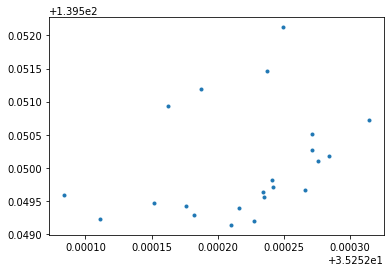

In [10]:
plt.plot(comp['lat-deg'], comp['lng-deg'], '.')

,regatta,race,name,passingInstruction,controlPoint.@class,controlPoint.name,controlPoint.id,controlPoint.left.@class,controlPoint.left.name,controlPoint.left.id,controlPoint.left.type,controlPoint.right.@class,controlPoint.right.name,controlPoint.right.id,controlPoint.right.type,controlPoint.type,mark_nr,mark_nr_from_finish
0,Tokyo 2019 - 49er FX,R12 (49erFX),X - Start,None,ControlPointWithTwoMarks,X - Start,b'\xa0CCp\xa2\xcd\x017lGH\xf7PH#*',Mark,X-Start RC,b'\\D\x9a\xa0\xa21\x017H\x01H\xf7PH#*',BUOY,Mark,X-Start PIN,b'\\Q%0\xa21\x017H\x04H\xf7PH#*',BUOY,None,0,4


In [13]:
id_l = course['controlPoint.left.id'].values[0]
id_r = course['controlPoint.right.id'].values[0]



sql = """SELECT  *
  FROM marks_positions
  WHERE regatta = '{}'
  and race = '{}'
  and (id = {} or id = {})
  and [timepoint-ms] <= {}+1000
  and [timepoint-ms] >= {}-1000""".format(regName, raceName, idToText(id_l), idToText(id_r), st,st)
st_line = pd.read_sql_query(sql, con = engine, index_col=None, coerce_float=True,
                           params=None, parse_dates=None, chunksize=None)
st_line

,regatta,race,id,lat-deg,lng-deg,timepoint-ms
0,Tokyo 2019 - 49er FX,R12 (49erFX),b'\\D\x9a\xa0\xa21\x017H\x01H\xf7PH#*',35.252174,139.549007,1566276840000
1,Tokyo 2019 - 49er FX,R12 (49erFX),b'\\Q%0\xa21\x017H\x04H\xf7PH#*',35.252323,139.552210,1566276841000


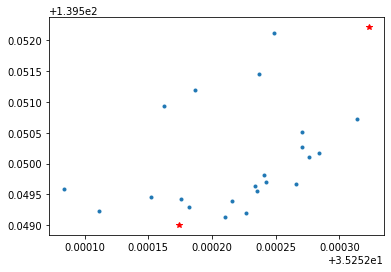

In [14]:
plt.plot(st_line['lat-deg'], st_line['lng-deg'], 'r*')
plt.plot(comp['lat-deg'], comp['lng-deg'], '.')
plt.show()

### get wind

In [4]:
## Needed functions
def windUrl(regName, raceName, windSource = '', windSourceId = ''):
    if len(windSourceId)>0:
        windSourceId = '&windsourceid={}'.format(windSourceId)
    url = 'https://www.sapsailing.com/sailingserver/api/v1/regattas/{}/races/{}/wind?windsource={}{}&fromtime=2012-01-01T10:12:03Z&totime=2050-12-31T10:12:03Z'.format(regName, raceName, windSource, windSourceId)
    return url



In [18]:
#regName, raceName given


data = requests.get(windUrl(regName,raceName), timeout = 100).json()

# windsources 
df = cd.transformJsonToPD(data, 'windsources')


# df = pd.DataFrame({k: [v] for k, v in data.items()})
# df = cd.expandListToRows(df, 'availableWindSources')
# df = cd.expandRecord(df, 'availableWindSources').drop(columns = 'windSources')
# df = df.rename(columns = {'name':'race'})
# df


In [19]:
import time
t = time.time()


r = requests.get(windUrl(regName,raceName, windSource = 'EXPEDITION', windSourceId = ''), timeout = 100).json()
r
# wind
def getWind(data):
    df = pd.DataFrame({k: [v] for k, v in data.items()})
    df = cd.expandListToRows(df, 'windSources')
    df['windSource'] = df.windSources.apply(lambda x: list(x.keys())[0])
    df['data'] = df.windSources.apply(lambda x: x[list(x.keys())[0]])
    df = df.drop(columns = ['windSources', 'availableWindSources'])
    df = cd.expandListToRows(df, 'data')
    df = cd.expandRecord(df, 'data')
    return df

all_df = getWind(r)


# from mlxtend.plotting import category_scatter

# fig = category_scatter(x='lng-deg', y='lat-deg', label_col='windSource', 
#                        data=all_df)


# r = requests.get(windUrl(regName,raceName, windSource = 'EXPEDITION', windSourceId = 'DC-FE-AAHJ'), timeout = 100).json()
# r
# df = getWind(r)
# df.windSource = df.windSource.apply(lambda x: 'New')
# fig = category_scatter(x='lng-deg', y='lat-deg', label_col='windSource', 
#                        data=df)
# together = all_df.append(df)
# fig = category_scatter(x='lng-deg', y='lat-deg', label_col='windSource', 
#                        data=together)
# do stuff
elapsed = time.time() - t
elapsed

2.7517335414886475

In [20]:
from_all = all_df[all_df.windSource == 'EXPEDITION-DC-FE-AAHJ']
plt.plot(df['timepoint-ms'], from_all['timepoint-ms'], '.')
plt.show()
plt.plot(df['timepoint-ms'], df['lat-deg'], 'o')
plt.plot(from_all['timepoint-ms'], from_all['lat-deg'], '.')
plt.plot(st, from_all['lat-deg'][from_all.index[0]], 'b*')
plt.show()
st

KeyError: 'timepoint-ms'

In [26]:
[print(x) for x in from_all.columns]
from_all.head()

name
regatta
windSource
trueBearing-deg
speed-kts
speed-m/s
timepoint-ms
dampenedTrueBearing-deg
dampenedSpeed-kts
dampenedSpeed-m/s
lat-deg
lng-deg


,name,regatta,windSource,trueBearing-deg,speed-kts,speed-m/s,timepoint-ms,dampenedTrueBearing-deg,dampenedSpeed-kts,dampenedSpeed-m/s,lat-deg,lng-deg
10669,R12 (49erFX),Tokyo 2019 - 49er FX,EXPEDITION-DC-FE-AAHJ,359.6,12.3,6.3,1566276540000,356.6,11.3,5.8,35.252102,139.548941
10670,R12 (49erFX),Tokyo 2019 - 49er FX,EXPEDITION-DC-FE-AAHJ,3.9,11.3,5.8,1566276540500,356.6,11.3,5.8,35.252102,139.548941
10671,R12 (49erFX),Tokyo 2019 - 49er FX,EXPEDITION-DC-FE-AAHJ,1.3,11.5,5.9,1566276541000,356.5,11.3,5.8,35.252102,139.548941
10672,R12 (49erFX),Tokyo 2019 - 49er FX,EXPEDITION-DC-FE-AAHJ,358.0,12.1,6.2,1566276541500,356.4,11.2,5.8,35.252102,139.548941
10673,R12 (49erFX),Tokyo 2019 - 49er FX,EXPEDITION-DC-FE-AAHJ,356.0,11.4,5.9,1566276542000,356.2,11.2,5.8,35.252102,139.548941


In [48]:

df = pd.DataFrame({k: [v] for k, v in data.items()})
df = cd.expandListToRows(df, 'windSources')
df['windSource'] = df.windSources.apply(lambda x: list(x.keys()))
df['data'] = df.windSources.apply(lambda x: x[list(x.keys())[0]])
df = cd.expandListToRows(df, 'data')
df = cd.expandRecord(df, 'data')

df
# df = cd.expandRecord(df, 'windSources')

NameError: name 'data' is not defined

# Correlations per race (first leg)

Insert new columns into legs, for correlations of # of tacks, side of course, average SOG, traveled distance



In [ ]:
cursor.execute("""
ALTER TABLE legs
ADD correlation_jibes decimal(5,4)
""")

In [ ]:
cursor.commit()

In [45]:
## not yet right for other legs then 1, because avg side needs to be calculated first

sql = """
SELECT * from legs
where leg_nr = 1
    """

legs = pd.read_sql(sql, engine)


for index, row in legs.iterrows():
    print(row['regatta'], row['race'], row['leg_nr'])
    
    sql = """
    SELECT * from comp_leg
    WHERE regatta = '{}'
    and race = '{}'
    and leg_nr = {}
    """.format( row['regatta'],
                row['race'],
                row['leg_nr'])

    df = pd.read_sql(sql, engine)
    corrs = df.corr().rel_rank
    corrs = corrs.replace(np.nan, "NULL", regex=True)  ### replace NaN's by NULL so they can be updated in the sql df
    
    
    cursor.execute("""
    UPDATE legs
    SET    legs.correlation_tacks = {}
          ,legs.correlation_side = {}
          ,legs.correlation_avgSOG = {}
          ,legs.correlation_traveledDistance = {}
          ,legs.correlation_jibes = {}
    WHERE
    regatta = '{}'
    and race = '{}'
    and leg_nr = '{}'
      """.format(corrs['competitor_tacks'],
                 corrs['avg_side'],
                 corrs['competitor_averageSOG-kts'],
                 corrs['competitor_distanceTraveled-m'],
                 corrs['competitor_jibes'],                 
                 row['regatta'],
                 row['race'],
                 row['leg_nr']))
    cursor.commit()


Tokyo 2019 - 49er R1 (49er) 1
Tokyo 2019 - 49er R1 (49er) 2
Tokyo 2019 - 49er R1 (49er) 3
Tokyo 2019 - 49er R1 (49er) 4
Tokyo 2019 - 49er R10 (49er) 1
Tokyo 2019 - 49er R10 (49er) 2
Tokyo 2019 - 49er R10 (49er) 3
Tokyo 2019 - 49er R10 (49er) 4
Tokyo 2019 - 49er R11 (49er) 1
Tokyo 2019 - 49er R11 (49er) 2
Tokyo 2019 - 49er R11 (49er) 3
Tokyo 2019 - 49er R11 (49er) 4
Tokyo 2019 - 49er R12 (49er) 1
Tokyo 2019 - 49er R12 (49er) 2
Tokyo 2019 - 49er R12 (49er) 3
Tokyo 2019 - 49er R12 (49er) 4
Tokyo 2019 - 49er R13 Medal (49er) 1
Tokyo 2019 - 49er R13 Medal (49er) 2
Tokyo 2019 - 49er R13 Medal (49er) 3
Tokyo 2019 - 49er R13 Medal (49er) 4
Tokyo 2019 - 49er R2 (49er) 1
Tokyo 2019 - 49er R2 (49er) 2
Tokyo 2019 - 49er R2 (49er) 3
Tokyo 2019 - 49er R2 (49er) 4
Tokyo 2019 - 49er R3 (49er) 1
Tokyo 2019 - 49er R3 (49er) 2
Tokyo 2019 - 49er R3 (49er) 3
Tokyo 2019 - 49er R3 (49er) 4
Tokyo 2019 - 49er R4 (49er) 1
Tokyo 2019 - 49er R4 (49er) 2
Tokyo 2019 - 49er R4 (49er) 3
Tokyo 2019 - 49er R4 (49er) 4


Tokyo 2019 - 49er FX R7 (49erFX) 1
Tokyo 2019 - 49er FX R7 (49erFX) 2
Tokyo 2019 - 49er FX R7 (49erFX) 3
Tokyo 2019 - 49er FX R7 (49erFX) 4
Tokyo 2019 - 49er FX R8 (49erFX) 1
Tokyo 2019 - 49er FX R8 (49erFX) 2
Tokyo 2019 - 49er FX R8 (49erFX) 3
Tokyo 2019 - 49er FX R8 (49erFX) 4
Tokyo 2019 - 49er FX R9 (49erFX) 1
Tokyo 2019 - 49er FX R9 (49erFX) 2
Tokyo 2019 - 49er FX R9 (49erFX) 3
Tokyo 2019 - 49er FX R9 (49erFX) 4
Toyko 2019 - 470 Women R1 (470 Women) 1
Toyko 2019 - 470 Women R1 (470 Women) 2
Toyko 2019 - 470 Women R1 (470 Women) 3
Toyko 2019 - 470 Women R1 (470 Women) 4
Toyko 2019 - 470 Women R1 (470 Women) 5
Toyko 2019 - 470 Women R1 (470 Women) 6
Toyko 2019 - 470 Women R10 (470 Women) 1
Toyko 2019 - 470 Women R10 (470 Women) 2
Toyko 2019 - 470 Women R10 (470 Women) 3
Toyko 2019 - 470 Women R10 (470 Women) 4
Toyko 2019 - 470 Women R10 (470 Women) 5
Toyko 2019 - 470 Women R10 (470 Women) 6
Toyko 2019 - 470 Women R11 Medal (470 Women) 1
Toyko 2019 - 470 Women R11 Medal (470 Women) 2


Tokyo 2019 - RS:X Men R10 (RS:X Men) 2
Tokyo 2019 - RS:X Men R10 (RS:X Men) 3
Tokyo 2019 - RS:X Men R10 (RS:X Men) 4
Tokyo 2019 - RS:X Men R10 (RS:X Men) 5
Tokyo 2019 - RS:X Men R10 (RS:X Men) 6
Tokyo 2019 - RS:X Men R11 Medal (RS:X Men) 1
Tokyo 2019 - RS:X Men R11 Medal (RS:X Men) 2
Tokyo 2019 - RS:X Men R11 Medal (RS:X Men) 3
Tokyo 2019 - RS:X Men R11 Medal (RS:X Men) 4
Tokyo 2019 - RS:X Men R11 Medal (RS:X Men) 5
Tokyo 2019 - RS:X Men R2 (RS:X men) 1
Tokyo 2019 - RS:X Men R2 (RS:X men) 2
Tokyo 2019 - RS:X Men R2 (RS:X men) 3
Tokyo 2019 - RS:X Men R2 (RS:X men) 4
Tokyo 2019 - RS:X Men R2 (RS:X men) 5
Tokyo 2019 - RS:X Men R3 (RS:X Men) 1
Tokyo 2019 - RS:X Men R3 (RS:X Men) 2
Tokyo 2019 - RS:X Men R3 (RS:X Men) 3
Tokyo 2019 - RS:X Men R3 (RS:X Men) 4
Tokyo 2019 - RS:X Men R3 (RS:X Men) 5
Tokyo 2019 - RS:X Men R4 (RS:X Men) 1
Tokyo 2019 - RS:X Men R4 (RS:X Men) 2
Tokyo 2019 - RS:X Men R4 (RS:X Men) 3
Tokyo 2019 - RS:X Men R4 (RS:X Men) 4
Tokyo 2019 - RS:X Men R4 (RS:X Men) 5
Tokyo 2019

In [31]:
corrs

leg_nr                                NaN
competitor_distanceTraveled-m    0.393843
competitor_averageSOG-kts       -0.736360
competitor_tacks                -0.174134
competitor_jibes                      NaN
competitor_penaltyCircles             NaN
competitor_rank                  0.999955
competitor_gapToLeader-s         0.951535
competitor_gapToLeader-m        -0.087007
competitor_started                    NaN
competitor_finished                   NaN
avg_side                        -0.181693
most_left                       -0.119541
most_right                       0.255104
rel_rank                         1.000000
Name: rel_rank, dtype: float64

In [30]:
sql = """
SELECT * from comp_leg
WHERE leg_nr = 1
and regatta = 'Tokyo 2019 - 49er'
and race = 'R1 (49er)'
"""

df = pd.read_sql(sql, engine)
corrs  = df.corr().rel_rank
corrs['competitor_averageSOG-kts']

-0.7363602419111945

In [11]:


for index, row in legs1.iterrows():
    print(row['regatta'], row['race'] , row['comp_id'])
    
    if row['competitor_started'] == 1 and row['competitor_finished'] and row['avg_side']!= None:
        print('getting track')
        sql = """SELECT  *
          FROM positions
          WHERE regatta = '""" + row['regatta'] + \
          """'and race = '"""+ row['race'] + \
          """'and comp_id = '"""+ row['comp_id'] + \
          """'and leg_nr = 1"""
        track = pd.read_sql_query(sql, con = engine, index_col=None, coerce_float=True, params=None, parse_dates=None, chunksize=None)
#         print(track.head())
        if not track.empty:
            print('calculating stats')
            stats = [str(x) for x in trackStatistics(track)]
            cursor.execute("""
            UPDATE comp_leg
            SET    comp_leg.avg_side = """ + stats[0] +"""
                   ,comp_leg.most_left = """ + stats[1] +"""
                   ,comp_leg.most_right = """ + stats[2] +"""
            WHERE
            regatta = '""" + row['regatta'] + \
              """'and race = '"""+ row['race'] + \
              """'and comp_id = '"""+ row['comp_id'] + \
              """'and leg_nr = 1
              """)
            cursor.commit()